# Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [1]:
# Initialize PySpark
APP_NAME = "Debugging Prediction Problems"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


# Hello, World!

Loading data, mapping it and collecting the records into RAM...

In [2]:
# Load the text file using the SparkContext
csv_lines = sc.textFile("../data/example.csv")

# Map the data to split the lines into a list
data = csv_lines.map(lambda line: line.split(","))

# Collect the dataset into local RAM
data.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

# Creating Objects from CSV using `pyspark.RDD.map`

Using a function with a map operation to create objects (dicts) as records...

In [3]:
# Turn the CSV lines into objects
def csv_to_record(line):
  parts = line.split(",")
  record = {
    "name": parts[0],
    "company": parts[1],
    "title": parts[2]
  }
  return record

# Apply the function to every record
records = csv_lines.map(csv_to_record)

# Inspect the first item in the dataset
records.first()

{'name': 'Russell Jurney', 'company': 'Relato', 'title': 'CEO'}

# `pyspark.RDD.groupBy`

Using the groupBy operator to count the number of jobs per person...

In [5]:
# Group the records by the name of the person
grouped_records = records.groupBy(lambda x: x["name"])

# Show the first group
grouped_records.first()

# Count the groups
job_counts = grouped_records.map(
  lambda x: {
    "name": x[0],
    "job_count": len(x[1])
  }
)

job_counts.collect()

[{'name': 'Florian Liebert', 'job_count': 1},
 {'name': 'Russell Jurney', 'job_count': 2},
 {'name': 'Don Brown', 'job_count': 1},
 {'name': 'Steve Jobs', 'job_count': 1},
 {'name': 'Donald Trump', 'job_count': 1}]

# Map vs FlatMap

We need to understand the difference between the map and flatmap operators. Map groups items per-record, while flatMap creates a single large group of items.

In [6]:
# Compute a relation of words by line
words_by_line = csv_lines\
  .map(lambda line: line.split(","))

words_by_line.collect()

[['Russell Jurney', 'Relato', 'CEO'],
 ['Florian Liebert', 'Mesosphere', 'CEO'],
 ['Don Brown', 'Rocana', 'CIO'],
 ['Steve Jobs', 'Apple', 'CEO'],
 ['Donald Trump', 'The Trump Organization', 'CEO'],
 ['Russell Jurney', 'Data Syndrome', 'Principal Consultant']]

In [7]:
# Compute a relation of words
flattened_words = csv_lines\
  .map(lambda line: line.split(","))\
  .flatMap(lambda x: x)

flattened_words.collect()

['Russell Jurney',
 'Relato',
 'CEO',
 'Florian Liebert',
 'Mesosphere',
 'CEO',
 'Don Brown',
 'Rocana',
 'CIO',
 'Steve Jobs',
 'Apple',
 'CEO',
 'Donald Trump',
 'The Trump Organization',
 'CEO',
 'Russell Jurney',
 'Data Syndrome',
 'Principal Consultant']

# Creating Rows

We can create `pyspark.sql.Rows` out of python objects so you we create `pyspark.sql.DataFrames`. This is desirable because once we have `DataFrames` we can run Spark SQL on our data.

In [11]:
from pyspark.sql import Row

# Convert the CSV into a pyspark.sql.Row
def csv_to_row(line):
  parts = line.split(",")
  row = Row(
    name=parts[0],
    company=parts[1],
    title=parts[2]
  )
  return row

# Apply the function to get rows in an RDD
rows = csv_lines.map(csv_to_row)
rows

PythonRDD[20] at RDD at PythonRDD.scala:48

# Creating `DataFrames` from `RDDs`

Using the `RDD.toDF()` method to create a dataframe, registering the `DataFrame` as a temporary table with Spark SQL, and counting the jobs per person using Spark SQL.

In [15]:
# Convert to a pyspark.sql.DataFrame
rows_df = rows.toDF()

# Register the DataFrame for Spark SQL
rows_df.registerTempTable("executives")

# Generate a new DataFrame with SQL using the SparkSession
job_counts = spark.sql("""
SELECT
  name,
  COUNT(*) AS total
  FROM executives
  GROUP BY name
""")
job_counts.show()

# Go back to an RDD
job_counts.rdd.collect()

+---------------+-----+
|           name|total|
+---------------+-----+
|   Donald Trump|    1|
|Florian Liebert|    1|
|      Don Brown|    1|
| Russell Jurney|    2|
|     Steve Jobs|    1|
+---------------+-----+



[Row(name='Donald Trump', total=1),
 Row(name='Florian Liebert', total=1),
 Row(name='Don Brown', total=1),
 Row(name='Russell Jurney', total=2),
 Row(name='Steve Jobs', total=1)]

## Creating `RDDs` from `DataFrames`

We can easily convert back from a `DataFrame` to an `RDD` using the `pyspark.sql.DataFrame.rdd()` method, along with `pyspark.sql.Row.asDict()` if we desire a Python `dict` of our records.

In [24]:
job_counts.rdd.map(lambda x: x.asDict()).collect()

[{'name': 'Donald Trump', 'total': 1},
 {'name': 'Florian Liebert', 'total': 1},
 {'name': 'Don Brown', 'total': 1},
 {'name': 'Russell Jurney', 'total': 2},
 {'name': 'Steve Jobs', 'total': 1}]

# Loading and Inspecting Parquet Files

Using the `SparkSession` to load files as `DataFrames` and inspecting their contents...

In [28]:
# Load the parquet file containing flight delay records
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# Register the data for Spark SQL
on_time_dataframe.registerTempTable("on_time_performance")

# Check out the columns
on_time_dataframe.columns

['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'Carrier',
 'TailNum',
 'FlightNum',
 'Origin',
 'OriginCityName',
 'OriginState',
 'Dest',
 'DestCityName',
 'DestState',
 'DepTime',
 'DepDelay',
 'DepDelayMinutes',
 'TaxiOut',
 'TaxiIn',
 'WheelsOff',
 'WheelsOn',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'Cancelled',
 'Diverted',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'CRSDepTime',
 'CRSArrTime']

In [29]:
# Trim the fields and keep the result
trimmed_on_time = on_time_dataframe\
  .select(
    "FlightDate",
    "TailNum",
    "Origin",
    "Dest",
    "Carrier",
    "DepDelay",
    "ArrDelay"
  )

# Sample 0.01% of the data and show
trimmed_on_time.sample(False, 0.0001).show(10)

+----------+-------+------+----+-------+--------+--------+
|FlightDate|TailNum|Origin|Dest|Carrier|DepDelay|ArrDelay|
+----------+-------+------+----+-------+--------+--------+
|2015-01-11| N153PQ|   ATL| GSP|     EV|    10.0|     7.0|
|2015-01-11| N391HA|   LAX| HNL|     HA|    -3.0|   -13.0|
|2015-01-11| N813MQ|   GSO| LGA|     MQ|   -11.0|   -21.0|
|2015-01-13| N181UW|   LAX| CLT|     US|    48.0|    41.0|
|2015-01-14| N337NB|   DTW| DCA|     DL|     6.0|    -4.0|
|2015-01-15| N797AA|   JFK| LAX|     AA|    -5.0|   -64.0|
|2015-01-15| N627AS|   SEA| MSP|     AS|    -4.0|   -16.0|
|2015-01-15| N502NK|   MCO| LBE|     NK|     6.0|    22.0|
|2015-01-15| N923WN|   AUS| LAX|     WN|    -5.0|     2.0|
|2015-01-16| N325US|   MDW| ATL|     DL|     7.0|   -15.0|
+----------+-------+------+----+-------+--------+--------+
only showing top 10 rows



## `DataFrame` Workflow: Calculating Speed in Dataflow and SQL

We can go back and forth between dataflow programming and SQL programming using `pyspark.sql.DataFrames`. This enables us to get the best of both worlds from these two APIs. For example, if we want to group records and get a total count for each group... a SQL `SELECT/GROUP BY/COUNT` is the most direct way to do it. On the other hand, if we want to filter data, a dataflow API call like `DataFrame.filter()` is the cleanest way. This comes down to personal preference for the user. In time you will develop your own style of working.

### Dataflow Programming

If we were to look at the `AirTime` along with the `Distance`, we could get a good idea of how fast the airplanes were going. Pretty cool! Lets do this using Dataflows first.

#### Trimming Our Data

First lets select just the two columns of interest: `AirTime` and `Distance`. We can always go back and select more columns if we want to extend our analysis, but trimming uneeded fields optimizes performance right away.

In [38]:
fd = on_time_dataframe.select("AirTime", "Distance")
fd.show(6)

+-------+--------+
|AirTime|Distance|
+-------+--------+
|   59.0|   432.0|
|   77.0|   432.0|
|  129.0|   802.0|
|   93.0|   731.0|
|  111.0|   769.0|
|  108.0|   769.0|
+-------+--------+
only showing top 6 rows



#### From Minutes to Hours

Now lets convert our `AirTime` from minutes to hours by dividing by 60.

In [41]:
hourly_fd = fd.select((fd.AirTime / 60).alias('Hours'), "Distance")
hourly_fd.show(5)

+------------------+--------+
|             Hours|Distance|
+------------------+--------+
|0.9833333333333333|   432.0|
|1.2833333333333334|   432.0|
|              2.15|   802.0|
|              1.55|   731.0|
|              1.85|   769.0|
+------------------+--------+
only showing top 5 rows



#### Raw Calculation

Now lets calculate miles per hour!

In [54]:
miles_per_hour = hourly_fd.select(
    (hourly_fd.Distance / hourly_fd.Hours).alias('Mph')
)
miles_per_hour.show(10)

+------------------+
|               Mph|
+------------------+
| 439.3220338983051|
| 336.6233766233766|
| 373.0232558139535|
|471.61290322580646|
| 415.6756756756757|
|427.22222222222223|
| 430.2739726027398|
|              null|
|              null|
|              null|
+------------------+
only showing top 10 rows



#### Investigating `nulls`

Looks like we have some errors in some records in our calculation because of missing fields? Lets bring back in the `Distance` and `AirTime` fields to see where the problem is coming from.

In [45]:
fd.select(
    "AirTime", 
    (fd.AirTime / 60).alias('Hours'), 
    "Distance"
).show()

+-------+------------------+--------+
|AirTime|             Hours|Distance|
+-------+------------------+--------+
|   59.0|0.9833333333333333|   432.0|
|   77.0|1.2833333333333334|   432.0|
|  129.0|              2.15|   802.0|
|   93.0|              1.55|   731.0|
|  111.0|              1.85|   769.0|
|  108.0|               1.8|   769.0|
|  146.0| 2.433333333333333|  1047.0|
|   null|              null|  1007.0|
|   null|              null|  1007.0|
|   null|              null|   802.0|
|   null|              null|   731.0|
|  122.0| 2.033333333333333|   731.0|
|   94.0|1.5666666666666667|   731.0|
|   91.0|1.5166666666666666|   731.0|
|  115.0|1.9166666666666667|   731.0|
|   89.0|1.4833333333333334|   731.0|
|  106.0|1.7666666666666666|   721.0|
|   94.0|1.5666666666666667|   748.0|
|   null|              null|   733.0|
|   null|              null|   733.0|
+-------+------------------+--------+
only showing top 20 rows



#### Filtering `nulls`

Now that we know some records are missing `AirTimes`, we can filter those records using `pyspark.sql.DataFrame.filter()`. Starting from the beginning, lets recalculate our values.

In [60]:
fd = on_time_dataframe.select("AirTime", "Distance")
filled_fd = fd.filter(fd.AirTime.isNotNull())
hourly_fd = filled_fd.select(
    "AirTime", 
    (filled_fd.AirTime / 60).alias('Hours'), 
    "Distance"
)
mph = hourly_fd.select((hourly_fd.Distance / hourly_fd.Hours).alias('Mph'))
mph.show(10)

+------------------+
|               Mph|
+------------------+
| 439.3220338983051|
| 336.6233766233766|
| 373.0232558139535|
|471.61290322580646|
| 415.6756756756757|
|427.22222222222223|
| 430.2739726027398|
| 359.5081967213115|
|466.59574468085106|
|  481.978021978022|
+------------------+
only showing top 10 rows



#### Averaging Speed

How fast does the fleet travel overall? Lets compute the average speed for the entire fleet.

In [62]:
mph.select(
    pyspark.sql.functions.avg(mph.Mph)
).show()

+------------------+
|          avg(Mph)|
+------------------+
|408.72370268222824|
+------------------+



It looks like the average speed of the fleet is 408 mph. Note how along the way we chekced the data for sanity, which led to confidence in our answer. SQL by contast can hide the internals of a query, which might have skewed our average significantly! 

### SQL-Based Speed Calculation

Now lets work the same thing out in SQL. Starting from the top:

In [65]:
on_time_dataframe.registerTempTable("on_time_performance")

mph = spark.sql("""
SELECT ( Distance / ( AirTime/60 ) ) AS Mph 
FROM on_time_performance 
WHERE AirTime IS NOT NULL
""")
mph.show(10)

+------------------+
|               Mph|
+------------------+
| 439.3220338983051|
| 336.6233766233766|
| 373.0232558139535|
|471.61290322580646|
| 415.6756756756757|
|427.22222222222223|
| 430.2739726027398|
| 359.5081967213115|
|466.59574468085106|
|  481.978021978022|
+------------------+
only showing top 10 rows



### Evaluating SQL

The SQL based solution seems to be better in this case, because we can simply express our calculation all in one place. When complexity grows however, it is best to break a single query into multiple stages where you use SQL or Dataflow programming to massage the data into shape.

# Calculating Histograms

Having computed the speed in miles per hour and the overall average speed of passenger jets in the US, lets dig deeper by using the `RDD` API's histogram method to calculate histograms buckets and values, which will then use to visualize data.

In [66]:
# Compute a histogram of departure delays
mph\
  .select("Mph")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(10)

([32.34375,
  107.89626024590164,
  183.4487704918033,
  259.0012807377049,
  334.5537909836066,
  410.10630122950823,
  485.65881147540983,
  561.2113217213115,
  636.7638319672132,
  712.3163422131148,
  787.8688524590165],
 [174, 14255, 148314, 643901, 1861699, 2357002, 664609, 23997, 32, 25])

# Visualizing Histograms

The problem with the output above is that it is hard to interpret. For better understanding, we need a visualization. We can use `matplotlib` inline in a Jupyter Notebook to visualize this distribution and see what the tendency of speed of airplanes is around the mean of 408 mph.

<BarContainer object of 10 artists>

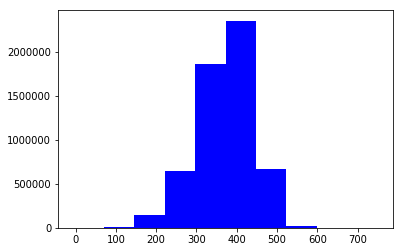

In [68]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Function to plot a histogram using pyplot
def create_hist(rdd_histogram_data):
  """Given an RDD.histogram, plot a pyplot histogram"""
  heights = np.array(rdd_histogram_data[1])
  full_bins = rdd_histogram_data[0]
  mid_point_bins = full_bins[:-1]
  widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
  bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
  return bar

# Compute a histogram of departure delays
departure_delay_histogram = mph\
  .select("Mph")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(10)

create_hist(departure_delay_histogram)

## Iterating on a Histogram

That looks interesting, but the bars seem to fat the really see what is going on. Lets double the number of buckets from 10 to 20. We can reuse the `create_hist()` method to do so.

<BarContainer object of 20 artists>

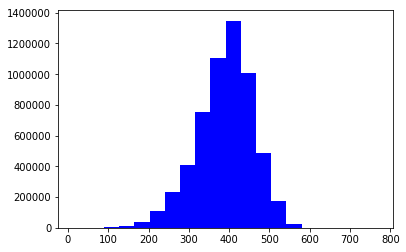

In [69]:
# Compute a histogram of departure delays
departure_delay_histogram = mph\
  .select("Mph")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(20)

create_hist(departure_delay_histogram)

## Speed Summary

You've now seen how to calculate different values in both SQL and Dataflow style, how to switch between the two methods, how to switch between the `pyspark.RDD` and `pyspark.sql.DataFrame` APIs and you're starting to build a proficiency in PySpark!

# Counting Airplanes in the US Fleet

Lets convert our `on_time_dataframe` (a `DataFrame`) into an `RDD` to calculate the total number of airplanes in the US fleet.

In [70]:
# Dump the unneeded fields
tail_numbers = on_time_dataframe.rdd.map(lambda x: x.TailNum)
tail_numbers = tail_numbers.filter(lambda x: x != '' and x is not None)

# distinct() gets us unique tail numbers
unique_tail_numbers = tail_numbers.distinct()

# now we need a count() of unique tail numbers
airplane_count = unique_tail_numbers.count()
print("Total airplanes: {}".format(airplane_count))

Total airplanes: 4897


# Exercise 1: Characterizing Airports

Using the techniques we demonstated above, calculate any 3 out of 4 of the following things using both the SQL and the Dataflow methods for each one. That is: implement each calculation twice - once in SQL and once using Dataflows. Try to use both the `RDD` and `DataFrame` APIs as you work.

1. How many airports are there in the united states?
2. What is the average flight time for flights arriving in San Francisco (SFO)? What does the distribution of this value look like? Plot a histogram using the `create_hist` method shown above.
3. Which American airport has the fastest out-bound speeds? What does the distribution of the flight speeds at this one airport look like? Plot a histogram using the `create_hist` method shown above.
4. What were the worst travel dates in terms of overall delayed flights in the US in 2015?

In [72]:
on_time_dataframe.columns

['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'FlightDate',
 'Carrier',
 'TailNum',
 'FlightNum',
 'Origin',
 'OriginCityName',
 'OriginState',
 'Dest',
 'DestCityName',
 'DestState',
 'DepTime',
 'DepDelay',
 'DepDelayMinutes',
 'TaxiOut',
 'TaxiIn',
 'WheelsOff',
 'WheelsOn',
 'ArrTime',
 'ArrDelay',
 'ArrDelayMinutes',
 'Cancelled',
 'Diverted',
 'ActualElapsedTime',
 'AirTime',
 'Flights',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'CRSDepTime',
 'CRSArrTime']

# Using `RDDs` and Map/Reduce to Prepare a Complex Record

In [ ]:
# Filter down to the fields we need to identify and link to a flight
flights = on_time_dataframe.rdd.map(lambda x: 
  (x.Carrier, x.FlightDate, x.FlightNum, x.Origin, x.Dest, x.TailNum)
  )

# Group flights by tail number, sorted by date, then flight number, then origin/dest
flights_per_airplane = flights\
  .map(lambda nameTuple: (nameTuple[5], [nameTuple[0:5]]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'TailNum': tuple[0], 
        'Flights': sorted(tuple[1], key=lambda x: (x[1], x[2], x[3], x[4]))
      }
    )
flights_per_airplane.first()

# Counting Late Flights

In [ ]:
total_flights = on_time_dataframe.count()

# Flights that were late leaving...
late_departures = on_time_dataframe.filter(
  on_time_dataframe.DepDelayMinutes > 0
)
total_late_departures = late_departures.count()
print(total_late_departures)

# Flights that were late arriving...
late_arrivals = on_time_dataframe.filter(
  on_time_dataframe.ArrDelayMinutes > 0
)
total_late_arrivals = late_arrivals.count()
print(total_late_arrivals)

# Get the percentage of flights that are late, rounded to 1 decimal place
pct_late = round((total_late_arrivals / (total_flights * 1.0)) * 100, 1)

# Counting Flights with Hero Captains

"Hero Captains" are those that depart late but make up time in the air and arrive on time or early.

In [ ]:
# Flights that left late but made up time to arrive on time...
on_time_heros = on_time_dataframe.filter(
  (on_time_dataframe.DepDelayMinutes > 0)
  &
  (on_time_dataframe.ArrDelayMinutes <= 0)
)
total_on_time_heros = on_time_heros.count()
print(total_on_time_heros)

# Printing Our Results

In [ ]:
print("Total flights:   {:,}".format(total_flights))
print("Late departures: {:,}".format(total_late_departures))
print("Late arrivals:   {:,}".format(total_late_arrivals))
print("Recoveries:      {:,}".format(total_on_time_heros))
print("Percentage Late: {}%".format(pct_late))

# Computing the Average Lateness Per Flights

In [ ]:
# Get the average minutes late departing and arriving
spark.sql("""
SELECT
  ROUND(AVG(DepDelay),1) AS AvgDepDelay,
  ROUND(AVG(ArrDelay),1) AS AvgArrDelay
FROM on_time_performance
"""
).show()

# Inspecting Late Flights

In [ ]:
# Why are flights late? Lets look at some delayed flights and the delay causes
late_flights = spark.sql("""
SELECT
  ArrDelayMinutes,
  WeatherDelay,
  CarrierDelay,
  NASDelay,
  SecurityDelay,
  LateAircraftDelay
FROM
  on_time_performance
WHERE
  WeatherDelay IS NOT NULL
  OR
  CarrierDelay IS NOT NULL
  OR
  NASDelay IS NOT NULL
  OR
  SecurityDelay IS NOT NULL
  OR
  LateAircraftDelay IS NOT NULL
ORDER BY
  FlightDate
""")
late_flights.sample(False, 0.01).show()

# Determining Why Flights Are Late

In [ ]:
# Calculate the percentage contribution to delay for each source
total_delays = spark.sql("""
SELECT
  ROUND(SUM(WeatherDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_weather_delay,
  ROUND(SUM(CarrierDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_carrier_delay,
  ROUND(SUM(NASDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_nas_delay,
  ROUND(SUM(SecurityDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_security_delay,
  ROUND(SUM(LateAircraftDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_late_aircraft_delay
FROM on_time_performance
""")
total_delays.show()

# Computing a Histogram of Weather Delayed Flights

In [ ]:
# Eyeball the first to define our buckets
weather_delay_histogram = on_time_dataframe\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

In [ ]:
create_hist(weather_delay_histogram)

# Preparing a Histogram for Visualization by d3.js

In [71]:
# Transform the data into something easily consumed by d3
def histogram_to_publishable(histogram):
  record = {'key': 1, 'data': []}
  for label, value in zip(histogram[0], histogram[1]):
    record['data'].append(
      {
        'label': label,
        'value': value
      }
    )
  return record

# Recompute the weather histogram with a filter for on-time flights
weather_delay_histogram = on_time_dataframe\
  .filter(
    (on_time_dataframe.WeatherDelay != None)
    &
    (on_time_dataframe.WeatherDelay > 0)
  )\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([0, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

record = histogram_to_publishable(weather_delay_histogram)
record

([0, 15, 30, 60, 120, 240, 480, 720, 1440.0], [0, 0, 0, 0, 0, 0, 0, 0])


{'key': 1,
 'data': [{'label': 0, 'value': 0},
  {'label': 15, 'value': 0},
  {'label': 30, 'value': 0},
  {'label': 60, 'value': 0},
  {'label': 120, 'value': 0},
  {'label': 240, 'value': 0},
  {'label': 480, 'value': 0},
  {'label': 720, 'value': 0}]}

# Building a Classifier Model to Predict Flight Delays

## Loading Our Data

In [ ]:
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType, TimestampType
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import udf

schema = StructType([
  StructField("ArrDelay", DoubleType(), True),     # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),    # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),    # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),     # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True), # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),     # "DepDelay":14.0
  StructField("Dest", StringType(), True),        # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),     # "Distance":368.0
  StructField("FlightDate", DateType(), True),    # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),   # "FlightNum":"6109"
  StructField("Origin", StringType(), True),      # "Origin":"TUS"
])

features = spark.read.json(
  "../data/simple_flight_delay_features.jsonl.bz2",
  schema=schema
)
features.first()

## Check Data for Nulls

In [ ]:
#
# Check for nulls in features before using Spark ML
#
null_counts = [(column, features.where(features[column].isNull()).count()) for column in features.columns]
cols_with_nulls = filter(lambda x: x[1] > 0, null_counts)
print(list(cols_with_nulls))

## Add a Route Column

Demonstrating the addition of a feature to our model...

In [ ]:
#
# Add a Route variable to replace FlightNum
#
from pyspark.sql.functions import lit, concat

features_with_route = features.withColumn(
  'Route',
  concat(
    features.Origin,
    lit('-'),
    features.Dest
  )
)
features_with_route.select("Origin", "Dest", "Route").show(5)

## Bucketizing ArrDelay into ArrDelayBucket

In [ ]:
#
# Use pysmark.ml.feature.Bucketizer to bucketize ArrDelay
#
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -15.0, 0, 30.0, float("inf")]
bucketizer = Bucketizer(
  splits=splits,
  inputCol="ArrDelay",
  outputCol="ArrDelayBucket"
)
ml_bucketized_features = bucketizer.transform(features_with_route)

# Check the buckets out
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show()

## Indexing Our String Fields into Numeric Fields

In [ ]:
#
# Extract features tools in with pyspark.ml.feature
#
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Turn category fields into categoric feature vectors, then drop intermediate fields
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "Route"]:
  string_indexer = StringIndexer(
    inputCol=column,
    outputCol=column + "_index"
  )
  ml_bucketized_features = string_indexer.fit(ml_bucketized_features)\
                                          .transform(ml_bucketized_features)

# Check out the indexes
ml_bucketized_features.show(6)

## Combining Numeric Fields into a Single Vector

In [ ]:
# Handle continuous, numeric fields by combining them into one feature vector
numeric_columns = ["DepDelay", "Distance"]
index_columns = ["Carrier_index", "DayOfMonth_index",
                   "DayOfWeek_index", "DayOfYear_index", "Origin_index",
                   "Origin_index", "Dest_index", "Route_index"]
vector_assembler = VectorAssembler(
  inputCols=numeric_columns + index_columns,
  outputCol="Features_vec"
)
final_vectorized_features = vector_assembler.transform(ml_bucketized_features)

# Drop the index columns
for column in index_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

# Check out the features
final_vectorized_features.show()

## Training Our Model in an Experimental Setup

In [ ]:
#
# Cross validate, train and evaluate classifier
#

# Test/train split
training_data, test_data = final_vectorized_features.randomSplit([0.7, 0.3])

# Instantiate and fit random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(
  featuresCol="Features_vec",
  labelCol="ArrDelayBucket",
  maxBins=4657,
  maxMemoryInMB=1024
)
model = rfc.fit(training_data)

# Evaluate model using test data
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="ArrDelayBucket", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = {}".format(accuracy))

# Check a sample
predictions.sample(False, 0.001, 18).orderBy("CRSDepTime").show(6)